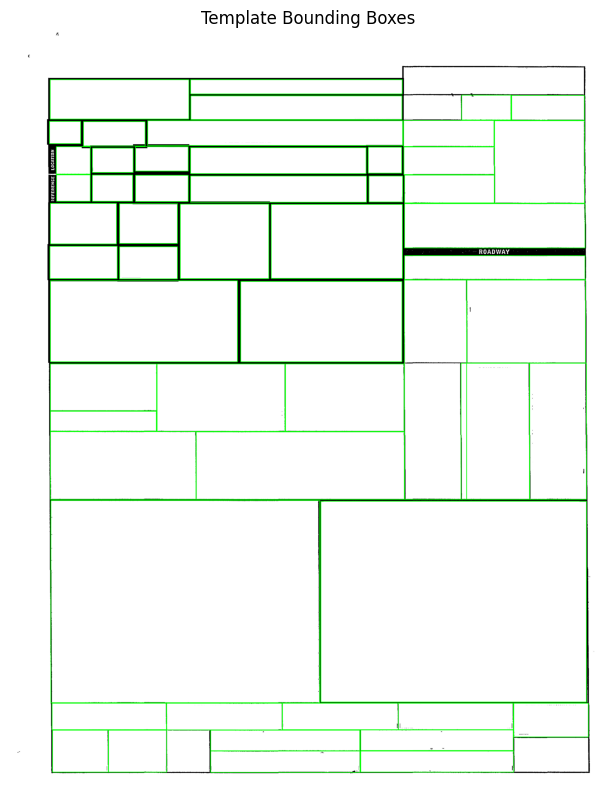

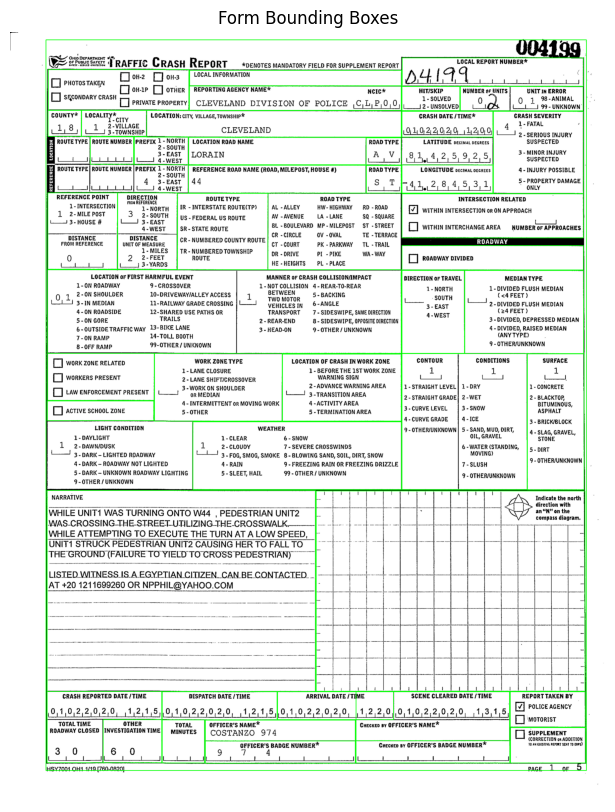

[(833, 3025, 1473, 3120), (1476, 3024, 2132, 3119), (2135, 2968, 2455, 3119), (833, 2936, 1473, 3025), (649, 2935, 830, 3119), (397, 2934, 647, 3118), (2134, 2815, 2454, 2966), (1476, 2815, 2131, 3024), (1141, 2815, 1636, 2934), (649, 2815, 1139, 2935), (158, 2814, 647, 3118), (1306, 1958, 2453, 2813), (158, 1956, 1303, 2814), (780, 1663, 1670, 1952), (159, 1574, 613, 1658), (1162, 1374, 1669, 1660), (2207, 1373, 2449, 1953), (1672, 1372, 2206, 1952), (616, 1371, 1161, 1660), (160, 1371, 615, 1572), (1940, 1017, 2447, 1372), (1672, 1017, 1939, 1371), (160, 1014, 1669, 1371), (1672, 911, 2446, 1015), (1672, 690, 2446, 878), (714, 688, 1100, 1014), (459, 686, 713, 1013), (161, 686, 458, 1012), (1520, 569, 1669, 687), (761, 568, 1519, 687), (1672, 567, 2060, 687), (1519, 451, 1669, 567), (762, 449, 1519, 566), (530, 447, 761, 566), (342, 447, 527, 564), (2062, 338, 2446, 689), (1672, 338, 2060, 448), (583, 334, 1669, 448), (305, 334, 583, 445), (162, 334, 304, 445), (1921, 232, 2445, 336)

In [9]:
import cv2
import numpy as np
import os
import re
from pdf2image import convert_from_path
import pytesseract
import matplotlib.pyplot as plt


# Function to convert a PDF to images
def convert_pdf_to_images(pdf_path, output_folder, dpi=300):
    images = convert_from_path(pdf_path, dpi=dpi)
    image_files = []
    for i, image in enumerate(images):
        image_path = os.path.join(output_folder, f"page_{i + 1}.png")
        image.save(image_path, "PNG")
        image_files.append(image_path)
    return image_files


# Function to preprocess images (blur and edge detection)
def preprocess_image(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    edges = cv2.Canny(blurred_image, 100, 175)
    return edges


# Function to get bounding boxes from contours
def get_bounding_boxes(contours, min_area=100, min_width=100, min_height=50):
    boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(contour)
            if w > min_width and h > min_height:
                boxes.append((x, y, x + w, y + h))
    return boxes


# Function to process PDF and extract information
def process_pdf_file(pdf_path, template_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    # Convert the PDF to images
    image_files = convert_pdf_to_images(pdf_path, output_folder)

    # Load the first image from the PDF and the template
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    form = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)

    if template is None or form is None:
        print(f"Error: Template or form image is missing.")
        return

    # Resize form to match template size
    form = cv2.resize(form, (template.shape[1], template.shape[0]))

    # Preprocess both images (blur and edge detection)
    edges_template = preprocess_image(template)
    edges_form = preprocess_image(form)

    # Find contours in both images
    contours_template, _ = cv2.findContours(
        edges_template, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contours_form, _ = cv2.findContours(
        edges_form, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Get bounding boxes from the contours
    template_boxes = get_bounding_boxes(contours_template)
    form_boxes = get_bounding_boxes(contours_form)

    if not template_boxes or not form_boxes:
        print(f"No bounding boxes detected in {pdf_path}")
        return

    # Visualize bounding boxes for debugging
    draw_bounding_boxes(template, template_boxes, "Template Bounding Boxes")
    draw_bounding_boxes(form, form_boxes, "Form Bounding Boxes")

    # Extract matching boxes from the form
    extract_regions_and_save(
        template_boxes, form_boxes, form, output_folder, "202000001607"
    )


# Function to draw bounding boxes on the image (for debugging/visualization)
def draw_bounding_boxes(image, boxes, title):
    image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for x1, y1, x2, y2 in boxes:
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


# Function to extract matching regions and save the boxes
def extract_regions_and_save(
    template_boxes, form_boxes, form, output_folder, cad_id
):
    output_boxes_folder = os.path.join(output_folder, "boxes")
    os.makedirs(output_boxes_folder, exist_ok=True)

    extracted_images = []
    box_count = 0
    officer_narrative = "UNKNOWN EVENTS"
    severity_desc = "UNKNOWN INJURY CAUSED BY "

    for x1, y1, x2, y2 in template_boxes:
        for fx1, fy1, fx2, fy2 in form_boxes:
            if abs(x1 - fx1) < 75 and abs(y1 - fy1) < 75:
                extracted_region = form[fy1:fy2, fx1:fx2]

                extracted_images.append(extracted_region)
                box_count += 1
                box_image_path = os.path.join(
                    output_boxes_folder, f"box_{box_count}.png"
                )

                cv2.imwrite(box_image_path, extracted_region)

                text = pytesseract.image_to_string(extracted_region)
                text = re.sub(r"\s+", " ", text).strip().upper()
                if "NARRATIVE" in text:
                    officer_narrative = text[10:]
                if "SEVERITY" in text:
                    severity = text[15:16]
                    severity_desc = interpret_severity(severity)

    oh1_narrative = severity_desc + officer_narrative
    narrative_file_path = os.path.join(
        output_folder, f"oh1_narrative_{cad_id}.txt"
    )

    with open(narrative_file_path, "w") as f:
        f.write(oh1_narrative)


# Function to interpret the severity code
def interpret_severity(severity_code):
    severity_map = {
        "1": "FATAL INJURY CAUSED BY ",
        "2": "SERIOUS INJURY CAUSED BY ",
        "3": "MINOR INJURY CAUSED BY ",
        "4": "INJURY POSSIBLE CAUSED BY ",
        "5": "PROPERTY DAMAGE CAUSED BY ",
    }
    return severity_map.get(severity_code, "UNKNOWN INJURY CAUSED BY ")


# Example usage
pdf_file_path = "../data/raw/oh1_pdf_files/202000001607.pdf"
output_folder = "../data/raw/oh1_pdf_files/202000001607"
template_path = "../data/raw/page_1_template.png"

process_pdf_file(pdf_file_path, template_path, output_folder)